# AMC + Demodulation Using Decision Tree

## Import libraries

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from comms import awgn, make_rrc, modulate, demodulate, pulse_shape

## Define baseline

In [2]:
sps = 4
span = 10

hrrc = make_rrc(num_weights=sps*span+1, fs=sps)

In [3]:
def calc_baseline(snr, M=2, num_iter=512, sps=8, span=10):
    ints = np.random.randint(low=0, high=M, size=(num_iter))
    samples = modulate(ints, M=M)
    hrrc = make_rrc(num_weights=sps*span+1, fs=sps)
    samples = pulse_shape(samples, hrrc, sps=sps)
    samples = awgn(samples, snr, measured=True)

    syms_filtered = np.convolve(samples, hrrc, mode='same')
    extract_symbols = syms_filtered[np.arange(0,len(samples),sps)]
    extract_symbols /= np.sqrt(np.mean(np.abs(extract_symbols)**2)) # normalize to unit power
    
    num_correct = sum(demodulate(extract_symbols, M=M) == ints)
    
    return num_correct/num_iter

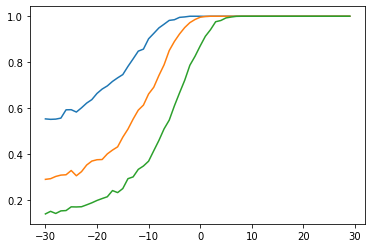

In [4]:
snr_range = np.arange(-30,30)

bpsk_baseline, qpsk_baseline, psk_baseline = [], [], []
for snr in snr_range:
    bpsk_baseline.append(calc_baseline(snr=snr, M=2, num_iter=2048))
    qpsk_baseline.append(calc_baseline(snr=snr, M=4, num_iter=2048))
    psk_baseline.append(calc_baseline(snr=snr, M=8, num_iter=2048))

plt.plot(snr_range, bpsk_baseline)
plt.plot(snr_range, qpsk_baseline)
plt.plot(snr_range, psk_baseline)

## Generate training data

In [5]:
def gen_mod_data(num_examples, seq_length, mod_order=4, sps=4, span=10, snr=50, normalize=True):
    
    num_weights= sps*span+1
    hrrc = make_rrc(num_weights=num_weights, fs=sps)
    
    ints = np.random.randint(low=0, high=mod_order, size=(num_examples * seq_length))
    samples = modulate(ints, M=mod_order)
    samples_pulse_shaped = pulse_shape(samples, hrrc, sps=sps)
    samples_noisy = awgn(samples_pulse_shaped, snr)
    
    data = samples_noisy.reshape(num_examples,-1)
    
    labels = ints.reshape(num_examples,-1)
    
    if normalize:
        data = (data/np.max(np.abs(data),axis=1)[:,None])
    
    return data, labels

def gen_data(num_examples=512, seq_length=5, sps=4, snr=50, normalize=True):
    bpsk_data, bpsk_labels = gen_mod_data(num_examples, seq_length, mod_order=2, sps=sps, snr=snr)
    qpsk_data, qpsk_labels = gen_mod_data(num_examples, seq_length, mod_order=4, sps=sps, snr=snr)
    qpsk_labels += 2
    
    x = np.concatenate((bpsk_data, qpsk_data))
    y = np.concatenate((bpsk_labels, qpsk_labels))
    
    return x, y

In [6]:
# If training on multiple snrs
datas, labels = [], []

snrs = np.arange(-5,21,5)
# snrs = [-10,-5,0]
for snr in snrs:
    xt, yt = gen_data(num_examples=4096, seq_length=10, snr=snr)
    datas.append(xt)
    labels.append(yt)
    
x_train = np.concatenate((datas))
y_train = np.concatenate((labels))
# x, y = to_tensors(x, y, batch_first=True, gpu=True, onehot=True)

In [7]:
print(snrs)
print(x_train.shape)
print(y_train.shape)

[-5  0  5 10 15 20]
(49152, 40)
(49152, 10)


In [8]:
def extract_inst(x):
    inst_abs = np.abs(x)
    inst_ang = np.angle(x)
    inst_freq = np.diff(np.unwrap(inst_ang))
    
    return inst_abs, inst_ang, inst_freq

def create_feature_vec(x):
    feat_vecs = np.zeros((x.shape[0],15))
    
    for idx, wave in enumerate(x):
    
        inst_abs, inst_ang, inst_freq = extract_inst(wave)

        feat_vecs[idx, 0:5] = calc_moments(inst_abs)
        feat_vecs[idx, 5:10] = calc_moments(inst_ang)
        feat_vecs[idx, 10:15] = calc_moments(inst_freq)
    return feat_vecs

def calc_moments(x):
    m2 = np.mean((x-np.mean(x))**2) 
    m3 = np.mean((x-np.mean(x))**3)/(np.mean((x-np.mean(x))**2)**(3/2))
    m4 = np.mean((x-np.mean(x))**4)/(np.mean((x-np.mean(x))**2)**(2))-3
    m5 = np.mean((x-np.mean(x))**5)/(np.mean((x-np.mean(x))**2)**(5/2))
    m6 = np.mean((x-np.mean(x))**6)/(np.mean((x-np.mean(x))**2)**(3))
    
    return [m2, m3, m4, m5, m6]

def calc_moment(x, p, q):
    return np.mean((x**(p-q))*np.conj(x)**q)

# calc cumulants from this paper https://ieeexplore.ieee.org/document/7565127
def calc_cumulants(x):
    c20 = np.abs(calc_moment(x,2,0))
    c21 = np.abs(calc_moment(x,2,1))
    c40 = np.abs(calc_moment(x,4,0) - 3*calc_moment(x,2,0 )**2)
    c41 = np.abs(calc_moment(x,4,0) - 3*calc_moment(x,2,0)*calc_moment(x,2,1))
    c42 = np.abs(calc_moment(x,4,2) - np.abs(calc_moment(x,2,0))**2 - 2*calc_moment(x,2,1)**2)
    
    return np.array([c20, c21, c40, c41, c42])

In [9]:
def preprocess(x_train, y_train):
    x_train_feats = np.zeros((x_train.shape[0], 20))

    for idx, x in enumerate(x_train):
        x_train_feats[idx, 0:5] = calc_cumulants(x)
        x_train_feats[idx, 5:20] = create_feature_vec(x.reshape(1,-1))

    y_train_labels = np.unique(np.where(y_train<2, 0, 1),axis=1)
    
    return x_train_feats, y_train_labels

In [10]:
x_train_feats, y_train_labels = preprocess(x_train, y_train)

In [11]:
x_train_feats.shape

(49152, 20)

## Train DT classifier

In [12]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

In [13]:
clf = clf.fit(x_train_feats, y_train_labels)

## Evaluate classification accuracy

In [14]:
x_test, y_test = gen_data(num_examples=32, seq_length=15, snr=5, sps=4)

In [15]:
x_test, y_test = preprocess(x_test, y_test)

In [16]:
np.sum(y_test.T == clf.predict(x_test))/x_test.shape[0]

1.0

In [17]:
snr_range = np.arange(-30,30)
classification_accs = []

for snr in snr_range:
    x_test, y_test = gen_data(num_examples=512, seq_length=5, snr=snr)
    x_test, y_test = preprocess(x_test, y_test)
    
    classification_accs.append(np.sum(y_test.T == clf.predict(x_test))/x_test.shape[0])

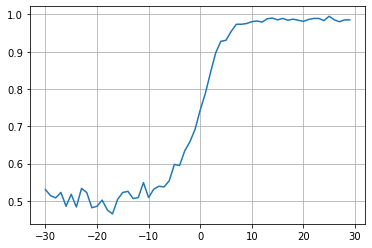

In [18]:
plt.plot(snr_range, classification_accs)
plt.grid()

In [19]:
#find average accuracy based on sequence length
seq_lengths = np.arange(5,51,5)

bpsk_accs = []

for length in seq_lengths:
    snr_range = np.arange(-30,30)
    classification_accs = []

    for snr in snr_range:
        x_test, y_test = gen_mod_data(num_examples=256, seq_length=length, mod_order=2, sps=sps, snr=snr)
        x_test, y_test = preprocess(x_test, y_test)

        classification_accs.append(np.sum(y_test.T == clf.predict(x_test))/x_test.shape[0])
    bpsk_accs.append(np.mean(classification_accs))

In [20]:
#find average accuracy based on sequence length
seq_lengths = np.arange(5,51,5)

qpsk_accs = []

for length in seq_lengths:
    snr_range = np.arange(-30,30)
    classification_accs = []

    for snr in snr_range:
        x_test, y_test = gen_mod_data(num_examples=256, seq_length=length, mod_order=4, sps=sps, snr=snr)
        y_test += 2
        x_test, y_test = preprocess(x_test, y_test)

        classification_accs.append(np.sum(y_test.T == clf.predict(x_test))/x_test.shape[0])
    qpsk_accs.append(np.mean(classification_accs))

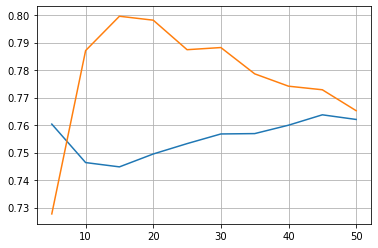

In [21]:
plt.plot(seq_lengths, bpsk_accs)
plt.plot(seq_lengths, qpsk_accs)
plt.grid()

## Combine into single receiver

In [22]:
def classify_demodulate(x):
    x_dt = np.zeros((20,))
    
    x_dt[0:5] = calc_cumulants(x)
    x_dt[5:20] = create_feature_vec(x.reshape(1,-1))
    y_hat = clf.predict(x_dt.reshape(1,-1))

    syms_filtered = np.convolve(x, hrrc, mode='same')
    extract_symbols = syms_filtered[np.arange(0,len(x),sps)]

    if y_hat == 0:
        y = demodulate(extract_symbols, M=2)
    elif y_hat == 1:
        y = demodulate(extract_symbols, M=4)
    else:
        raise Exception('unexpected class prediction')
    
    return y

In [23]:
x_test, y_test = gen_data(num_examples=32, seq_length=10, snr=5)

In [24]:
y_test[0]

array([1, 1, 0, 0, 0, 1, 1, 0, 1, 0])

In [25]:
classify_demodulate(x_test[0])

array([1, 1, 0, 0, 0, 1, 1, 0, 1, 0])

In [26]:
x_test, y_test = gen_mod_data(32, 15, mod_order=2, sps=4, span=10, snr=5)

y_hat = classify_demodulate(x_test[0])
print(y_hat==y_test[0])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]


In [27]:
accuracies_bpsk = []

for snr in snr_range:
    x_test, y_test = gen_mod_data(1024, 10, mod_order=2, sps=4, span=10, snr=snr)
    
    num_correct = 0
    
    for idx, x in enumerate(x_test):
        y_hat = classify_demodulate(x)
        num_correct += np.sum(y_hat==y_test[idx])
        
    accuracies_bpsk.append(num_correct/y_test.size)

In [28]:
accuracies_qpsk = []

for snr in snr_range:
    x_test, y_test = gen_mod_data(1024, 10, mod_order=4, sps=4, span=10, snr=snr)
    
    num_correct = 0
    
    for idx, x in enumerate(x_test):
        y_hat = classify_demodulate(x)
        num_correct += np.sum(y_hat==y_test[idx])
        
    accuracies_qpsk.append(num_correct/y_test.size)

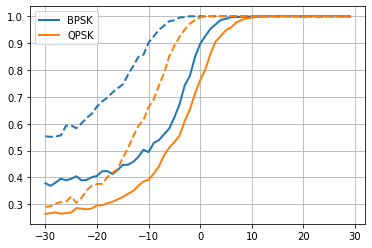

In [29]:
plt.plot(snr_range, accuracies_bpsk, linewidth=2)
plt.plot(snr_range, accuracies_qpsk, linewidth=2)
# plt.plot(snr_range, classification_accs)
plt.plot(snr_range, bpsk_baseline, 'C0--', linewidth=2)
plt.plot(snr_range, qpsk_baseline, 'C1--', linewidth=2)
plt.grid()
plt.legend(('BPSK', 'QPSK'))

In [30]:
np.savez('results/dt_baselines.npz', bpsk_baseline=accuracies_bpsk, qpsk_baseline=accuracies_qpsk, snr_range=snr_range)
np.savez('results/mf_baselines.npz', bpsk_baseline=bpsk_baseline, qpsk_baseline=qpsk_baseline, snr_range=snr_range)

## Find average demodulation success based on seq length

In [31]:
seq_lengths = np.arange(5,50,5)

bpsk_class_accs = []

for length in seq_lengths:
    accuracies_bpsk = []

    for snr in snr_range:
        x_test, y_test = gen_mod_data(512, length, mod_order=2, sps=4, span=10, snr=snr)

        num_correct = 0

        for idx, x in enumerate(x_test):
            y_hat = classify_demodulate(x)
            num_correct += np.sum(y_hat==y_test[idx])

        accuracies_bpsk.append(num_correct/y_test.size)
    bpsk_class_accs.append(np.mean(accuracies_bpsk))

In [32]:
seq_lengths = np.arange(5,50,5)

qpsk_class_accs = []

for length in seq_lengths:
    accuracies_qpsk = []

    for snr in snr_range:
        x_test, y_test = gen_mod_data(512, length, mod_order=4, sps=4, span=10, snr=snr)

        num_correct = 0

        for idx, x in enumerate(x_test):
            y_hat = classify_demodulate(x)
            num_correct += np.sum(y_hat==y_test[idx])

        accuracies_qpsk.append(num_correct/y_test.size)
    qpsk_class_accs.append(np.mean(accuracies_qpsk))

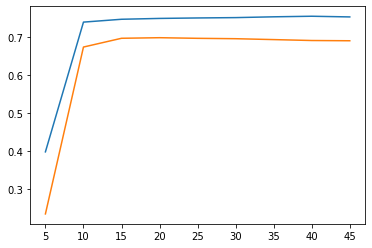

In [33]:
plt.plot(seq_lengths, bpsk_class_accs)
plt.plot(seq_lengths, qpsk_class_accs)

In [34]:
seq_lengths

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45])

# Train models on multiple seq lengths

In [35]:
train_seq_lengths = [5, 10, 20]
test_seq_lengths = [5, 10, 20]
data_size = 256
snr_range = np.arange(-30, 31, 5)

In [36]:
for seq_length in train_seq_lengths:
    # If training on multiple snrs
    datas, labels = [], []

    snrs = np.arange(-5,21,5)
    # snrs = [-10,-5,0]
    for snr in snrs:
        xt, yt = gen_data(num_examples=data_size, seq_length=seq_length, snr=snr)
        datas.append(xt)
        labels.append(yt)

    x_train = np.concatenate((datas))
    y_train = np.concatenate((labels))
    
    x_train, y_train = preprocess(x_train, y_train)
    
    np.savez(f'data/dt_train_data_multi_snr_{seq_length}_{data_size}.npz', x_train=x_train, y_train=y_train)

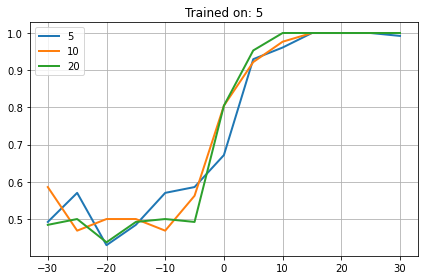

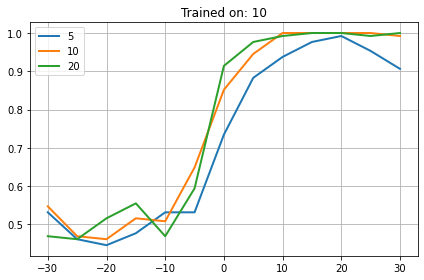

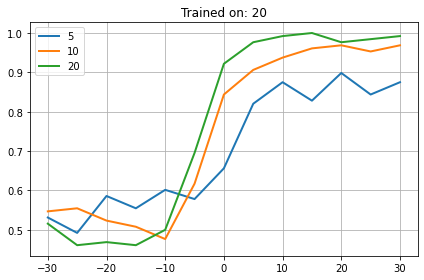

In [37]:
for seq_length in train_seq_lengths:
    
    dataset = np.load(f'data/dt_train_data_multi_snr_{seq_length}_{data_size}.npz')
    x_train = dataset['x_train']
    y_train = dataset['y_train']
    
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(x_train, y_train)
    
    plt.figure()
    for test_seq_length in test_seq_lengths:
        classification_accs = []
        for snr in snr_range:
            x_test, y_test = gen_data(num_examples=64, seq_length=test_seq_length, snr=snr)
            x_test, y_test = preprocess(x_test, y_test)

            classification_accs.append(np.sum(y_test.T == clf.predict(x_test))/x_test.shape[0])

    #     plt.figure()
        plt.plot(snr_range, classification_accs, linewidth=2)
    plt.title(f'Trained on: {seq_length}')
    plt.legend(test_seq_lengths)
    plt.grid()
    plt.tight_layout()

Surprisingly training seq_length of 5 seems most reasonable...

In [38]:
snr_range = np.arange(-30, 31)

dataset = np.load(f'data/dt_train_data_multi_snr_10_{data_size}.npz')
x_train = dataset['x_train']
y_train = dataset['y_train']

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

In [39]:
num_runs = 256

In [40]:
accuracies_bpsk = []

for snr in snr_range:
    x_test, y_test = gen_mod_data(num_runs, seq_length=10, mod_order=2, sps=4, span=10, snr=snr)
    
    num_correct = 0
    
    for idx, x in enumerate(x_test):
        y_hat = classify_demodulate(x)
        num_correct += np.sum(y_hat==y_test[idx])
        
    accuracies_bpsk.append(num_correct/y_test.size)

In [41]:
accuracies_qpsk = []

for snr in snr_range:
    x_test, y_test = gen_mod_data(num_runs, seq_length=10, mod_order=4, sps=4, span=10, snr=snr)
    
    num_correct = 0
    
    for idx, x in enumerate(x_test):
        y_hat = classify_demodulate(x)
        num_correct += np.sum(y_hat==y_test[idx])
        
    accuracies_qpsk.append(num_correct/y_test.size)

In [42]:
saved = np.load('results/dt_baselines.npz')

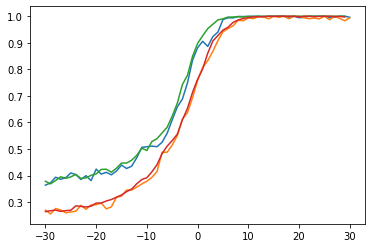

In [43]:
plt.plot(snr_range, accuracies_bpsk)
plt.plot(snr_range, accuracies_qpsk)
plt.plot(saved['snr_range'], saved['bpsk_baseline'])
plt.plot(saved['snr_range'], saved['qpsk_baseline'])